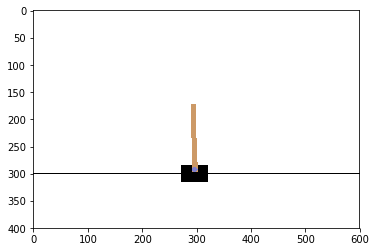

In [12]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))


In [21]:
#create agent
from sklearn.neural_network import MLPClassifier
print(n_actions)
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, list(range(n_actions)));

2


/home/otoshuki/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


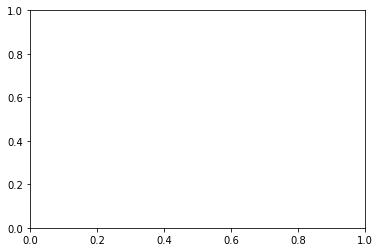

In [26]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)

In [36]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    for t in range(t_max):
        
        # a vector of action probabilities in current state
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p = probs)
        
        new_s, r, done, info = env.step(a)
#         ax.clear()
#         ax.imshow(env.render('rgb_array'))
#         fig.canvas.draw()
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states, actions, total_reward

In [15]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states  = []
    elite_actions = []
    for session in range(len(rewards_batch)):
        if rewards_batch[session] >= reward_threshold:
            for state in range(len(states_batch[session])):
                elite_states.append(states_batch[session][state])
                elite_actions.append(actions_batch[session][state])
    
    return elite_states, elite_actions

In [16]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


# Training loop
Generate sessions, select N best and fit to those

In [24]:
n_sessions = 100
percentile = 70
log = []
sessions = [generate_session() for sess in range(n_sessions)]
batch_states,batch_actions,batch_rewards = map(np.array, zip(*sessions))
elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)

print(batch_states.shape)

(100,)


mean reward = 100.000, threshold=100.000


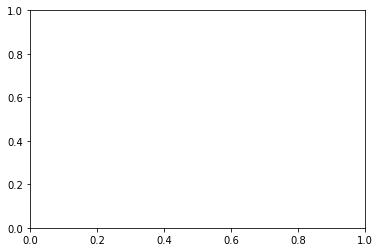

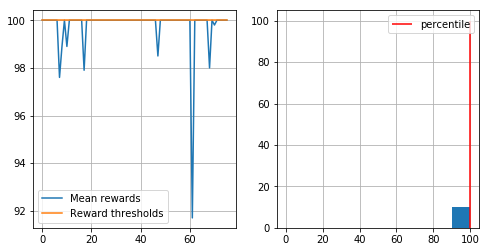

75


KeyboardInterrupt: 

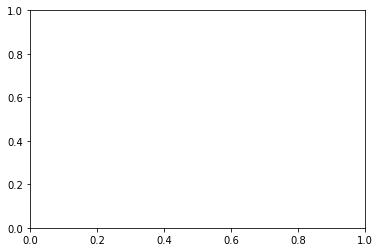

In [37]:
n_sessions = 100
percentile = 70
log = []
sss = 0

for iter in range(100):
    #generate new sessions
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sessions = [generate_session(100) for sess in range(n_sessions)]

    batch_states,batch_actions,batch_rewards = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    #<fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states,elite_actions)
    show_progress(batch_rewards, log, percentile, reward_range=[0,np.max(batch_rewards)])
    print(iter)
    if np.mean(batch_rewards)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [7]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

In [8]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices